In [32]:
import sys

import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import stats
import qp

sys.path.append("/Users/eleni/Desktop/pymaxent/")
from pymaxent import *

In [2]:
with h5py.File("nz_qp_lens.h5", "r") as f:
    Z_MID = f['Z_MID'][::]
    nz_0 = f['nz_0'][::]
    nz_1 = f['nz_1'][::]
    nz_2 = f['nz_2'][::]
    nz_3 = f['nz_3'][::]
    nz_4 = f['nz_4'][::]

The goal is to test the pymaxent algorithm on a DESC n(z). We will do so as follows:
https://www.sciencedirect.com/science/article/pii/S2352711019302456

* Step 1: Generate a mock data set obeying the DESC n(z)
* Step 2: Test on a Gaussian
* Step 3: Run pymaxent on these moments
* Step 4: Compare the recovered distribution with the DESC n(z)

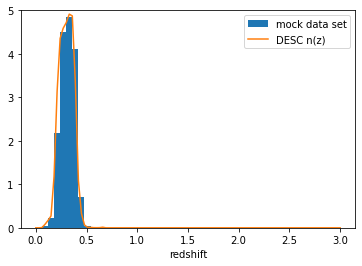

In [3]:
# Step 1

sample = np.random.choice(Z_MID, p = nz_0 / np.sum(nz_0), size = 100000)

plt.hist(sample, density = True, label = 'mock data set')
plt.plot(Z_MID, nz_0, label = 'DESC n(z)')
plt.xlabel("redshift")
plt.legend()
plt.ylim(0, 5)
plt.show()

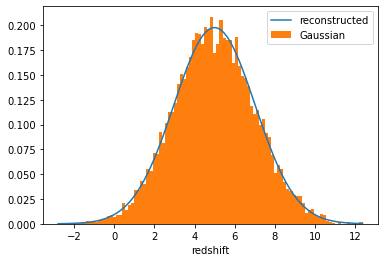

In [4]:
# Step 2

N = 3 # number of moments

sample = np.random.normal(5,2,10000)
binning = int(np.sqrt(len(sample)))

p,b = np.histogram(sample, bins=binning)
b = (b[1:] + b[:-1])/2

moments = np.zeros(N)

for i in range(N):
    moments[i] = np.sum(b**i*p)/len(sample)
    
bnd_low = min(sample)
bnd_high = max(sample)
x = np.linspace(bnd_low, bnd_high, binning)

sol, lambdas = reconstruct(moments, bnds=[bnd_low, bnd_high])

plt.plot(x, sol(x), label = 'reconstructed')
plt.hist(sample, label = 'Gaussian', density=True, bins=binning)
plt.legend()
plt.xlabel("redshift")
plt.show()

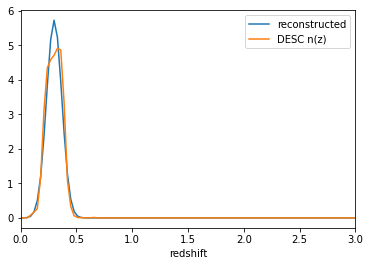

In [5]:
# Step 3: 

N = 3 # number of moments

x = Z_MID
p = nz_0

moments = np.zeros(N)

for i in range(N):
    moments[i] = np.sum(x**i*p)/((max(Z_MID)-min(Z_MID))/len(Z_MID))**(-1)
    
bnd_low = min(Z_MID)
bnd_high = max(Z_MID)

sol, lambdas = reconstruct(moments, bnds=[bnd_low, bnd_high])

# Step 4
plt.plot(x, sol(x), label = 'reconstructed')
plt.plot(Z_MID, nz_0, label = 'DESC n(z)')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()

In [5]:
def reconstruct_from_moments(p, x, N):
    
    bnd_low = min(x)
    bnd_high = max(x)

    moments = np.zeros(N)

    for i in range(N):
        moments[i] = np.sum(x**i*p)/((bnd_high-bnd_low)/len(x))**(-1)
    
    sol, lambdas = reconstruct(moments, bnds=[bnd_low, bnd_high])

    return x, sol(x)

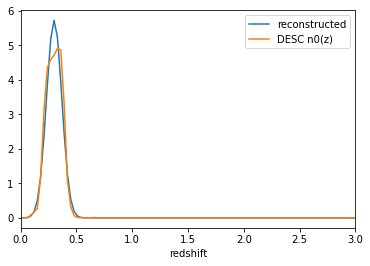

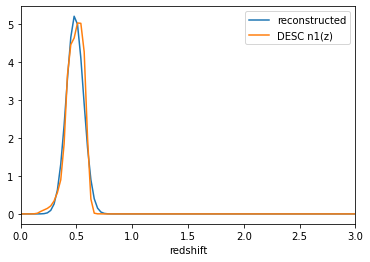

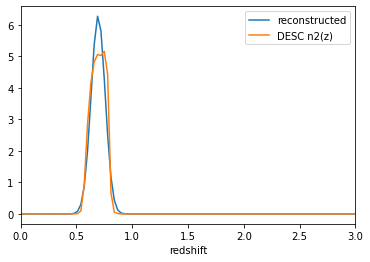

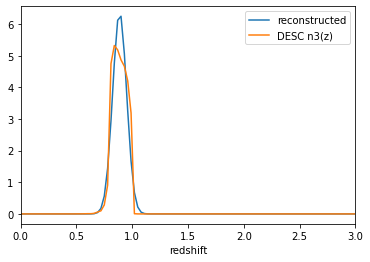

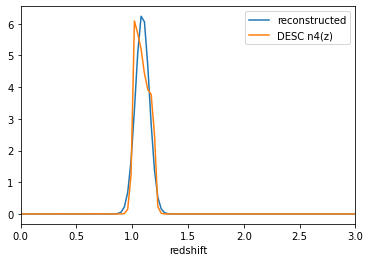

In [9]:
x, sol0 = reconstruct_from_moments(nz_0, Z_MID, 3)

plt.plot(x, sol0, label = 'reconstructed')
plt.plot(Z_MID, nz_0, label = 'DESC n0(z)')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()

x, sol1 = reconstruct_from_moments(nz_1, Z_MID, 3)

plt.plot(x, sol1, label = 'reconstructed')
plt.plot(Z_MID, nz_1, label = 'DESC n1(z)')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()

x, sol2 = reconstruct_from_moments(nz_2, Z_MID, 3)

plt.plot(x, sol2, label = 'reconstructed')
plt.plot(Z_MID, nz_2, label = 'DESC n2(z)')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()

x, sol3 = reconstruct_from_moments(nz_3, Z_MID, 3)

plt.plot(x, sol3, label = 'reconstructed')
plt.plot(Z_MID, nz_3, label = 'DESC n3(z)')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()

x, sol4 = reconstruct_from_moments(nz_4, Z_MID, 3)

plt.plot(x, sol4, label = 'reconstructed')
plt.plot(Z_MID, nz_4, label = 'DESC n4(z)')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()

21.60501089652512 11.069584788910795


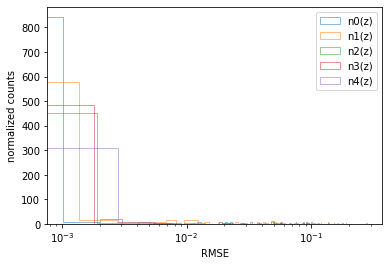

In [51]:
# Let's test the similarity between the reconstructed distribution and DESC n(z)'s

# KL divergence 

from scipy.special import rel_entr

# Draw samples from the DESC and reconstructed distributions to avoid infinity

sample_nz0 = np.random.choice(Z_MID, p = nz_0 / np.sum(nz_0), size = 1000)
sample_sol0 = np.random.choice(Z_MID, p = sol0 / np.sum(sol0), size = 1000)

print(sum(rel_entr(sample_nz0, sample_sol0)), sum(rel_entr(sample_sol0, sample_nz0)))

# RMSE

RMSE0 = np.array([qp.metrics.quick_rmse(p, q, N=len(nz_0)) for p, q in zip(nz_0, sol0)])
RMSE1 = np.array([qp.metrics.quick_rmse(p, q, N=len(nz_0)) for p, q in zip(nz_1, sol1)])
RMSE2 = np.array([qp.metrics.quick_rmse(p, q, N=len(nz_0)) for p, q in zip(nz_2, sol2)])
RMSE3 = np.array([qp.metrics.quick_rmse(p, q, N=len(nz_0)) for p, q in zip(nz_3, sol3)])
RMSE4 = np.array([qp.metrics.quick_rmse(p, q, N=len(nz_0)) for p, q in zip(nz_4, sol4)])

plt.hist(RMSE0, alpha=0.5, bins=100, label='n0(z)', density=True, histtype = "step")
plt.hist(RMSE1, alpha=0.5, bins=100, label='n1(z)', density=True, histtype = "step")
plt.hist(RMSE2, alpha=0.5, bins=100, label='n2(z)', density=True, histtype = "step")
plt.hist(RMSE3, alpha=0.5, bins=100, label='n3(z)', density=True, histtype = "step")
plt.hist(RMSE4, alpha=0.5, bins=100, label='n4(z)', density=True, histtype = "step")
plt.xlabel('RMSE')
plt.xscale("log")
plt.ylabel("normalized counts")
plt.legend()
plt.show()

## To-do

* Elaborate more on the Gaussian unit test
* Test on non-Gaussian distributions / mixture Gaussian
* Similarity tests: KL divergence etc.: https://github.com/aimalz/qtc2021/blob/main/intro.ipynb
* How does the similarity scale with number of moments?

(how does the number of moments used affect results?)

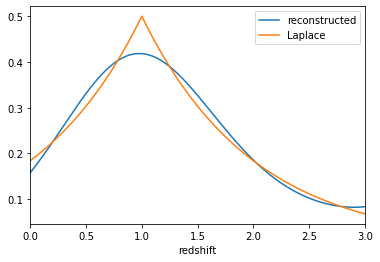

In [67]:
# Test on non-Gaussian continous distributions

xgrid = np.linspace(0, 3, 1000)

# E.g. the Laplace distribution has 5 moments and all of them are well-defined. 

p_laplace = stats.laplace.pdf(xgrid, 1)

x_laplace, sol_laplace = reconstruct_from_moments(p1, xgrid, 5)

plt.plot(x, sol, label = 'reconstructed')
plt.plot(xgrid, p_laplace, label = 'Laplace')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()

/Users/eleni/Desktop/pymaxent/pymaxent.py:95: RuntimeWarning: overflow encountered in exp
  return x**k * np.exp(np.dot(lamb, xi))
/Users/eleni/Desktop/pymaxent/pymaxent.py:95: RuntimeWarning: overflow encountered in double_scalars
  return x**k * np.exp(np.dot(lamb, xi))
/Users/eleni/Desktop/pymaxent/pymaxent.py:148: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rhs[k] = quad(integrand, a, b, args=(lamb, k))[0] - mu[k]
/Users/eleni/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


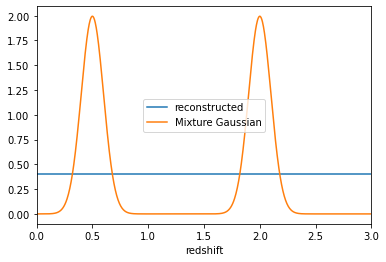

In [74]:
# E.g a bimodal distribution, such as a mixture Gaussian.

p_mixture = 0.5 * stats.norm.pdf(xgrid, 0.5, 0.1) + 0.5 * stats.norm.pdf(xgrid, 2, 0.1)
norm = np.trapz(p_mixture, xgrid)
p_mixture /= norm

x_mixture, sol_mixture = reconstruct_from_moments(p1, xgrid, 50)

plt.plot(x_mixture, sol_mixture, label = 'reconstructed')
plt.plot(xgrid, p_mixture, label = 'Mixture Gaussian')
plt.xlim(0, 3)
plt.legend()
plt.xlabel("redshift")
plt.show()